In [1]:
!wget http://jmcauley.ucsd.edu/data/amazon/qa/qa_Cell_Phones_and_Accessories.json.gz -O qa.gz

--2021-07-27 21:15:57--  http://jmcauley.ucsd.edu/data/amazon/qa/qa_Cell_Phones_and_Accessories.json.gz
Resolving jmcauley.ucsd.edu (jmcauley.ucsd.edu)... 137.110.160.73
Connecting to jmcauley.ucsd.edu (jmcauley.ucsd.edu)|137.110.160.73|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7116708 (6.8M) [application/x-gzip]
Saving to: ‘qa.gz’

qa.gz               100%[===================>]   6.79M  5.80MB/s    in 1.2s    

2021-07-27 21:15:59 (5.80 MB/s) - ‘qa.gz’ saved [7116708/7116708]



In [2]:
import ast

In [3]:
!gzip -d qa.gz

In [4]:
preguntas = []
respuestas = []
tipo_pregunta = []
tipo_respuesta = []
with open("qa","r") as f:
  for linea in f:
    d = ast.literal_eval(linea)
    preguntas.append(d["question"])
    respuestas.append(d["answer"])
    tipo_pregunta.append(d["questionType"])
    tipo_respuesta.append(d.get("answerType","-"))

In [5]:
set(tipo_respuesta)

{'-', '?', 'N', 'Y'}

In [6]:
set(tipo_pregunta)

{'open-ended', 'yes/no'}

In [7]:
{t:tipo_pregunta.count(t) for t in set(tipo_pregunta)}

{'open-ended': 36965, 'yes/no': 48900}

In [8]:
preguntas = []
respuestas = []
with open("qa","r") as f:
  for linea in f:
    d = ast.literal_eval(linea)
    if d["questionType"] == "open-ended":
      preguntas.append(d["question"])
      respuestas.append(d["answer"])

In [9]:
import pandas as pd
import sklearn.preprocessing as skp
import sklearn.feature_extraction.text as sktext
import numpy as np
import nltk

In [10]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [11]:
xencoder = sktext.TfidfVectorizer(stop_words=nltk.corpus.stopwords.words("english"))
xvectors = xencoder.fit_transform(preguntas).toarray()

In [12]:
xvectors.shape

(36965, 14199)

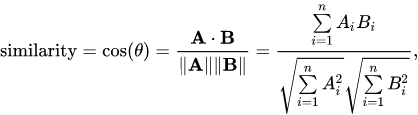

In [13]:
def CalcularCoseno(A,B):
  return np.dot(A,B) / ( np.sqrt((A**2).sum()) * np.sqrt((B**2).sum()) )

In [14]:
v0 = xvectors[0,:]
v1 = xvectors[1,:]

In [15]:
print(preguntas[0])
print(preguntas[1])

Why hasnt it upgraded to latest Android OS 4.4.2? Is it because it is unlocked? Some1 HELP ME!!!!!!
What is the warranty on this?


In [16]:
CalcularCoseno(v0,v1)

0.0

In [17]:
CalcularCoseno(v1,v1)

1.0

In [18]:
xpregunta = xencoder.transform(["what is the phone's android version?"]).toarray().squeeze()
CalcularCoseno(v0,xpregunta)

0.17609418835585605

In [19]:
xpregunta = xencoder.transform(["does it come in blue?"]).toarray().squeeze()
CalcularCoseno(v0,xpregunta)

0.0

In [20]:
xpregunta = xencoder.transform(["what is the phone's android version?"]).toarray().squeeze()
cosenos = CalcularCoseno(xvectors,xpregunta)

In [21]:
resultados = pd.DataFrame({"preguntas":preguntas,"respuestas":respuestas,"coseno":cosenos})
r = resultados[resultados["coseno"] > 0]
r.sort_values("coseno",ascending=False)[0:10]

,preguntas,respuestas,coseno
22424,which android version is the phone?,You can upgrade it to 2.3.7 at best. No other ...,0.005202
20294,what is the android version for this phone,"4.1.2 Jellybean, I believe.",0.005202
6644,What version of android does this phone have?,Hardware I510.06 Firmware 2.3.6 Baseband I510....,0.005202
26579,What version of Android is the phone,"hello 4.0.1 ping, whatsapp. line",0.005202
34317,what android version is in this phone?,4.1.2 latest firmware,0.005202
8334,what version of android does this phone have?,"Hi, Factory Release Android version was v2.3 (...",0.005202
15562,What version of Android does this have? Is it ...,Yes! 4.0.4 But Jelly Bean is available officia...,0.004943
7241,what version of android does it have?,"It originally came with 4.0, but it received r...",0.004943
23119,what android version have it?,I believe it is called Kit Kat.....I had the 4...,0.004943
18260,what have android version?,sorry but i don't know because i bought this p...,0.004943


In [22]:
def chat():
  cliente = input("welcome!, what is your name?: ")
  print("Hi,",cliente,"!")
  while True:
    pregunta = input("Enter your question [empy line to quit]: ")

    if len(pregunta.strip())==0:
      break;
    
    xpregunta = xencoder.transform([pregunta]).toarray().squeeze()
    cosenos = CalcularCoseno(xvectors,xpregunta)
    
    if len(cosenos[cosenos>0]) > 0:
      idx = np.where(cosenos == np.amax(cosenos) )[0][0]
      print(respuestas[idx])
    else:
      print("My answers are limited, you must ask the right questions")

  print("Bye!")
chat()

welcome!, what is your name?: Nixon
Hi, Nixon !
Enter your question [empy line to quit]: what android version is in the phone?
Hardware I510.06 Firmware 2.3.6 Baseband I510.06vfp8 Sch-i510.fp8 Does that answer your question
Enter your question [empy line to quit]: What's the best phone
None
Enter your question [empy line to quit]: 
Bye!


Si se necesita trabajar con un listado de preguntas que no cabe por completo en RAM para los cálculos de distancia, podemos hacer el cálculo por partes y juntarlo

In [23]:
def CalcularCosenos(xpreguntas, xpregunta):
  n = xpreguntas.shape[0]
  tamanio_grupo = 10_000
  ngrupos = n//tamanio_grupo
  resto = n % tamanio_grupo
  cosenos = np.array([])
  for i in range(0,tamanio_grupo*ngrupos,tamanio_grupo):
    r = CalcularCoseno(xpreguntas[i:i+tamanio_grupo,:].toarray(),xpregunta)
    cosenos  = np.append(cosenos, r)
  if resto > 0:
    inicio = tamanio_grupo*ngrupos
    r = CalcularCoseno(xpreguntas[inicio:inicio+resto,:].toarray(),xpregunta)
    cosenos  = np.append(cosenos, r)
  return cosenos

In [24]:
preguntas = []
respuestas = []
with open("qa","r") as f:
  for linea in f:
    d = ast.literal_eval(linea)
    preguntas.append(d["question"])
    respuestas.append(d["answer"])

In [25]:
xencoder = sktext.TfidfVectorizer(stop_words=nltk.corpus.stopwords.words("english"))
xvectors = xencoder.fit_transform(preguntas)
xpregunta = xencoder.transform(["what is the phone's android version?"]).toarray().squeeze()

In [26]:
import time
inicio = time.time()
cosenos = CalcularCosenos(xvectors,xpregunta)
print("secs=",time.time()-inicio)

secs= 10.103362798690796


In [27]:
resultados = pd.DataFrame({"preguntas":preguntas,"respuestas":respuestas,"coseno":cosenos})
r = resultados[resultados["coseno"] > 0]
r.sort_values("coseno",ascending=False)[0:10]

,preguntas,respuestas,coseno
18931,what version of android does this phone have?,"Hi, Factory Release Android version was v2.3 (...",0.010003
15050,What version of android does this phone have?,Hardware I510.06 Firmware 2.3.6 Baseband I510....,0.010003
52787,which android version is the phone?,You can upgrade it to 2.3.7 at best. No other ...,0.010002
62432,What version of Android is the phone,"hello 4.0.1 ping, whatsapp. line",0.010001
47825,what is the android version for this phone,"4.1.2 Jellybean, I believe.",0.010001
79925,what android version is in this phone?,4.1.2 latest firmware,0.010001
16389,what version of android does it have?,"It originally came with 4.0, but it received r...",0.009516
13363,what version of Android ?,It has the latest version. You will be fine!,0.009516
54395,what android version have it?,I believe it is called Kit Kat.....I had the 4...,0.009516
54610,which is the version of android?,"Hello. Android OS, v4.1.2 (Jelly Bean)",0.009516


#Word2Vect

In [32]:
!cp /content/drive/MyDrive/GoogleNews-vectors-negative300.bin.gz /content/vectors.bin.gz

In [33]:
!gzip -d vectors.bin.gz

In [2]:
import gensim
from gensim.models import KeyedVectors

In [3]:
modelo = KeyedVectors.load_word2vec_format('vectors.bin',binary=True)

In [4]:
len(modelo.wv.vocab)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.


3000000

In [5]:
print(modelo.vector_size)

300


In [6]:
modelo.most_similar(positive=["man","queen"],negative=["king"])

[('woman', 0.7609435319900513),
 ('girl', 0.6139994263648987),
 ('teenage_girl', 0.6040961742401123),
 ('teenager', 0.5825759172439575),
 ('lady', 0.5752554535865784),
 ('boy', 0.5077576637268066),
 ('policewoman', 0.5066847801208496),
 ('schoolgirl', 0.5052095651626587),
 ('blonde', 0.48696184158325195),
 ('person', 0.48637545108795166)]

In [7]:
modelo.most_similar(positive=["Rome","France"],negative=["Italy"],topn=1)

[('Paris', 0.7190686464309692)]

In [8]:
modelo.most_similar(positive=["man","doctor"],negative=["woman"],topn=5)

[('physician', 0.646366536617279),
 ('doctors', 0.5858404636383057),
 ('surgeon', 0.5723941326141357),
 ('dentist', 0.552364706993103),
 ('cardiologist', 0.5413815975189209)]